<a href="https://colab.research.google.com/github/rachit-shah/automated-learning-and-data-analysis/blob/master/hw2q2%20%20(Decision%20Tree%20from%20Scratch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
'''from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
'''

'from google.colab import files\n\nuploaded = files.upload()\n\nfor fn in uploaded.keys():\n  print(\'User uploaded file "{name}" with length {length} bytes\'.format(\n      name=fn, length=len(uploaded[fn])))\n'

In [0]:
#!pip install anytree
#!pip install graphviz
#!apt-get install graphviz

#Question 2 [Decision Tree]

####(20 points) [Decision Tree][Song Ju] In the given “hw2q2.csv”, all of the input features are nominal except for the first column, which is a ratio and continuous. The output label has two class values: T or F. Complete the following tasks using the decision tree algorithm discussed in the lecture. In the case of ties, break ties in favor of the leftmost feature. 

In [0]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import operator
#To display image from file
from IPython.display import Image
#To visualize tree using graphviz which uses dot language
from anytree import Node
from anytree.exporter import DotExporter

In [0]:
#Read csv file and assign proper labels to the columns
df = pd.read_csv('hw2q2.csv',header=None,names=["Value","Color","Size","Level","Temp","Class"])
df

,Value,Color,Size,Level,Temp,Class
0,3,BLUE,SMALL,LOW,COOL,F
1,7,BLUE,LARGE,HIGH,COOL,F
2,16,BLUE,LARGE,LOW,COOL,F
3,17,BLUE,LARGE,HIGH,COOL,F
4,27,BLUE,LARGE,HIGH,HOT,T
5,29,BLUE,SMALL,HIGH,HOT,T
6,33,BLUE,SMALL,LOW,HOT,F
7,34,BLUE,LARGE,HIGH,HOT,T
8,2,RED,LARGE,LOW,COOL,F
9,6,RED,SMALL,LOW,COOL,T


## Build Decision Tree Recursively

In [0]:
# Function to recursively build tree by selecting the best attribute at a split 
# using ID3/Gini and then recurse for the left and right child. It has the 
# following parameters:
# 1. node - the tree node at the current level either derived from the 
#    left or right child of the parent in prev level
# 2. data - the DataFrame at the current level after removing previous splits
# 3. level - the current level/depth of the tree
# 4. parent (default=None) - the parent node of the current node
# 5. Left (default=None) - Either True or False, whether the current node
#    is the left or right child of its parent
# 6. ID3 - whether to the use the ID3 or Gini Index for determining the split
countNode=0
def buildTree(node,data,level,parent=None,Left=None,ID3=True):
  Att = list(data.columns)  #List the Attributes left at the given level
  Att.remove("Class")       #Remove Class as it's not a feature
  global countNode
  countNode = countNode + 1
  #If homogeneous data at Class for current node value, reached leaf node
  if (same(data)):
    #Assign the most frequent(mode) of the Class to the leaf node result
    resultClass = data.Class.mode()[0]      
    #For printing result node for either left or right node of the parent
    print("All classes same")
    if(Left=="Left"):                       
      print("ResultClass for left node of '",parent,"' = ",resultClass)
    elif(Left=="Right"):
      print("ResultClass for right node of '",parent,"' = ",resultClass)
    #assign the value to the node for tree visualization using graphviz
    node.name = resultClass +" ("+str(countNode)+")"
    printTree()             #Print intermediate tree
   
  #Same as previous, reached leaf node, except because there's no attributes
  #left to split on, may have heterogeneous data
  elif not Att:       
    #Assign the most frequent(mode) of the Class to the leaf node result
    resultClass = data.Class.mode()[0]    
    #assign the value to the node for tree visualization using graphviz
    node.name = resultClass    +" ("+str(countNode)+")"           
    print("No attributes left")
    if(Left=="Left"):
      print("ResultClass for left node of '",parent,"' = ",resultClass)
    elif(Left=="Right"):
      print("ResultClass for right node of '",parent,"' = ",resultClass)
    printTree()
  #If haven't reached leaf, then for internal nodes check for which attribute 
  #to split on using either ID3 or Gini.
  else:
    #a is the best attribute selected and if the attribute is continuous, 
    #it will also return the split (the number) where to split
    if ID3:
      a, split = bestAttributeID3(data,Att,level,parent)
    else:
      a, split = bestAttributeGini(data,Att,level,parent)
    node.name = a +" ("+str(countNode)+")"  #Assign value to internal node of tree
    #Print best attribute found for left/right child of parent w/o given split
    print("\n")
    if Left=="Left":
      print("Best Attribute for left node of parent ",parent,\
            " for Level ",level," is ",a)
    elif Left=="Right":
      print("Best Attribute for right node of parent ",\
            parent," for Level ",level," is ",a)
    else:
      print("Best Attribute for root node for Level ",level," is ",a)
    if split:
      print("with split=",str(split))
    printTree()
    #recurse for left and right sub-trees. Create an empty node for both left
    #and right childs with a temporary "None" name which will be assigned to 
    #them at lower depths. Parent is assigned to current node for the child and
    #edge value of tree is the attribute value of parent for each child. 
    #We also select the rows corresponding to the attribute value attVals[i] and
    #drop the current node's column.
    #The edge values are different for categorical or continuous values
    if(isCategorical(a)):
      attVals = list(data[a].unique())
      buildTree(Node("None", parent=node, edge=attVals[0]),\
                data[data[a]==attVals[0]].drop(columns=a),level+1,a,"Left",ID3)
      buildTree(Node("None", parent=node, edge=attVals[1]),\
                data[data[a]==attVals[1]].drop(columns=a),level+1,a,"Right",ID3)
    ##Else for continuous attribute
    else:
      buildTree(Node("None", parent=node, edge="<"+str(split)),\
                data[data[a]<split].drop(columns=a),level+1,a,"Left",ID3)
      buildTree(Node("None", parent=node, edge=">="+str(split)),\
                data[data[a]>=split].drop(columns=a),level+1,a,"Right",ID3)

#Function for finding whether the Class column is homogeneous for given level
def same(data):
  #If only one unique value of Class, homogeneous
  if len(data.Class.unique()) == 1:
    return True
  else:
    return False

## Suppport Functions for Best Attribute Calculations

In [0]:
#Find Probability for givenClass w/o givenValue. For e.g., P(Color) for prob.
#corresponding to class values and P(Color=Red) for prob. corresponding to a 
#specific value of the attribute
def probability(data,givenClass,givenValue,overall=False):
  #for P(Color)
  if overall:
    if givenValue==None:
        valueCounts = data[givenClass].value_counts() #find count of unique vals
        if(len(valueCounts)==1):   #if homogeneous, prob = 1
          prob = 1
        else:                      #else p/p+n
          prob = valueCounts[0]/(valueCounts[0]+valueCounts[1])
        return prob
    else:
        valueCounts = data[data[givenClass]==givenValue].size #find count of unique vals
        return valueCounts/data.size
  #for P(Color=Red)
  else:
    data = data[data[givenClass] == givenValue] #subset with value of attribute
    valueCounts = data.Class.value_counts() #find unique counts for subset
    if(len(valueCounts)==1):               #if homogeneous, prob = 1
      prob = 1
    else:                                  #else p/p+n
      prob = valueCounts[0]/(valueCounts[0]+valueCounts[1])
    return prob

#Function to determine if a function is categorical or continuous from its dtype
def isCategorical(a):
  numeric = ["int32","int64","float32","float64"]
  categorical = ["object","O"]
  if df[a].dtype in numeric:
    return False  #if numeric, continuous
  else:
    return True   #else, categorical

#Probability function for continuous attributes
#same as categorical, except split is done < and >=
def probabilityContinuous(data,givenClass,split,ofSplit = False):
  if not ofSplit:
    return len(data[data[givenClass]<split])/len(data)
  else:
    data1 = data[data[givenClass] < split]
    data2 = data[data[givenClass] >= split]
    valueCounts = data1.Class.value_counts()
    #print("1 ",str(split)+"  ", valueCounts)
    if(len(valueCounts)==1):
      prob1 = 1
    else:
      prob1 = valueCounts[0]/(valueCounts[0]+valueCounts[1])
    valueCounts = data2.Class.value_counts()
    #print("2 ",str(split)+"  ",valueCounts)
    if(len(valueCounts)==1):
      prob2 = 1
    else:
      prob2 = valueCounts[0]/(valueCounts[0]+valueCounts[1])
    return prob1,prob2   #return prob for < and >=


## Best Attribute Calculation using ID3/Entropy

In [0]:
#H(X) = -Σ(p(X=c)*log2(p(X=c))
def entropy(prob):
  #print(prob)
  if(prob!=0 and prob!=1):
    return -(prob*math.log2(prob)+(1-prob)*math.log2(1-prob))
  else:
    return 0  #for homogeneous, entropy is 0

#Function to find the best attribute and the split value for given level
#using ID3/Entropy Calculations
def bestAttributeID3(data,Att,level,parent):
  print("LEVEL",str(level)," PARENT:",parent)
  computation = ""   #string for printing computations
  gains = []    #list of information gains for all attributes
  probClass = probability(data,"Class",None,True)  #P(Y) - Probability of Class
  classEntropy = entropy(probClass)           #H(Y) - Entropy of Class
  computation += "H(Class)="+str(classEntropy)+"\n"
  continuousSplits = {}    #dict of splits for all continuous attributes
  #Now, for each attribute we will calculate, H(Y|X)= Σ P(X=i)*H(X=i|Y) where
  # H(X=i|Y) = -Σ(p(X=c)*log2(P(X=c)))
  for x in Att:
    componentEntropy = 0
    # for categorical values
    if isCategorical(x):
      attVals = list(data[x].unique())  #list all unique values of attribute
      for y in attVals:
        probX = probability(data,x,y,True)  #P(X)
        probValue = probability(data,x,y)  #p(X=c)
        subCompEntropy = entropy(probValue) #H(X=c)
        computation += "Entropy(Class|"+x+"='"+y+"')="+str(subCompEntropy)+"\n"
        componentEntropy += probX*subCompEntropy    #H(Y|X)
      gains.append(classEntropy-componentEntropy)   #Append to list
      computation += "Entropy(Class|"+x+")="+str(componentEntropy)+"\n"
      computation += "Gain(Class|"+x+")="+str(classEntropy-componentEntropy)+"\n"
    #else for continuous attribute, determine where to split iteratively and 
    #take the split corresponding to maximum gain
    else:
      splitVal,splitGain = determineSplit(data,classEntropy,x)
      continuousSplits[x] = splitVal   #Add to dictionary of continuous att
      gains.append(splitGain)          #Append gain
  print(computation)
  #Now, select the attribute which gives the maximum information gain and return
  #it. If continuous also return the split value
  bestAttr = data.columns[gains.index(max(gains))]
  if(isCategorical(bestAttr)):
    return bestAttr, None
  else:
    return bestAttr, continuousSplits[bestAttr]
  
#Function to determine split for continuous attributes. Done by iterating over
#all possible splits and returning the one with maximum gain. H(X<i)
def determineSplit(data,classEntropy,givenClass):
  computation = ""
  #Take subset as we don't need other attributes and sort them according to vals
  data = data[[givenClass,"Class"]]
  data = data.sort_values(givenClass)
  data = data.reset_index(drop=True)
  gains = {}
  arr = list(data[givenClass].unique())[1:]   #unique values, iterate from 1
  #arr.append(arr[len(arr)-1]+1)
  #iterate for each possible split H(X<arr[i])
  for x in arr:
    #Same calculations as before
    #prob for continuous att
    probX = probabilityContinuous(data,givenClass,x) 
    lessThanProb, moreThanProb = probabilityContinuous(data,givenClass,x,True)
    lessThanEntropy = entropy(lessThanProb)
    computation += "Entropy(Class|"+givenClass+"<"+str(x)+")="+str(lessThanEntropy)+"\n"
    moreThanEntropy = entropy(moreThanProb)
    computation += "Entropy(Class|"+givenClass+">="+str(x)+")="+str(moreThanEntropy)+"\n"
    gain = classEntropy - ((probX*lessThanEntropy)+((1-probX)*moreThanEntropy))
    computation += "Gain(Class|"+givenClass+"="+str(x)+")="+str(gain)+"\n"
    gains[x]=gain
  split, maxgain = max(gains.items(), key=operator.itemgetter(1))
  computation += "Maximum gain is:"+str(maxgain)
  computation += " corresponding to split "+str(split)+"\n"
  print(computation)
  return split,maxgain 

##Best Attribute Calculation using GINI

In [0]:
#Function to find the best attribute and the split value for given level
#using Gini Index Calculations GINI(t)= 1- Σp(j|t)^2 and 
#GINI-Split=Σ(n_i/n)*GINI(i)

#Same as ID3 calculations but changing entropy functions to gini
def bestAttributeGini(data,Att,level,parent):
  print("LEVEL",str(level)," PARENT",parent)
  computation = ""
  attGini = []
  continuousSplits = {}
  for x in Att:
    componentGini = 0
    if isCategorical(x):
      attVals = list(data[x].unique())
      for y in attVals:
        probX = probability(data,x,y,True)
        probValue = probability(data,x,y)
        subCompGini = gini(probValue)
        computation += "Gini(Class|"+x+"='"+y+"')="+str(subCompGini)+"\n"
        componentGini += probX*subCompGini
      attGini.append(componentGini)
      computation += "Gini(Class|"+x+")="+str(componentGini)+"\n"
    else:
      splitVal,splitGain = determineSplitGini(data,x)
      continuousSplits[x] = splitVal
      attGini.append(splitGain)
  print(computation)
  bestAttr = data.columns[attGini.index(min(attGini))]
  if(isCategorical(bestAttr)):
    return bestAttr, None
  else:
    return bestAttr, continuousSplits[bestAttr]
  
#Calculate GINI(t)= 1- Σp(j|t)^2 
def gini(prob):
  #print(prob)
  if(prob!=0 and prob!=1):
    return 1-math.pow(prob,2)-math.pow(1-prob,2)
  else:
    return 0

#Function to determine split for continuous using gini
#instead of maximum, we minimize gini-split here
def determineSplitGini(data,givenClass):
  computation = ""
  data = data[[givenClass,"Class"]]
  data = data.sort_values(givenClass)
  data = data.reset_index(drop=True)
  gains = {}
  arr = list(data[givenClass].unique())[1:]
  #arr.append(arr[len(arr)-1]+1)
  for x in arr:
    probX = probabilityContinuous(data,givenClass,x)
    lessThanProb, moreThanProb = probabilityContinuous(data,givenClass,x,True)
    lessThanGini = gini(lessThanProb)
    computation += "Gini(Class|"+givenClass+"<"+str(x)+")="+str(lessThanGini)+"\n"
    moreThanGini = gini(moreThanProb)
    computation += "Gini(Class|"+givenClass+">="+str(x)+")="+str(moreThanGini)+"\n"
    gain = ((probX*lessThanGini)+((1-probX)*moreThanGini))
    computation += "GiniSplit(Class|"+givenClass+"="+str(x)+")="+str(gain)+"\n"
    gains[x]=gain
  split, mingini = min(gains.items(), key=operator.itemgetter(1))
  computation += "Minimum Gini-Split is:"+str(mingini)
  computation += " corresponding to split "+str(split)+"\n"
  print(computation)
  return split,mingini 

## Visualize tree using graphviz which uses dot language. anytree library helps create dot code 

In [0]:
#how to display node values
def nodenamefunc(node):
    return '%s:%s' % (node.name, node.depth)
#how to display edge values
def edgeattrfunc(node, child):
  return 'label="%s"' % (child.edge)
#how edge values represented in dot code
def edgetypefunc(node, child):
  return '--'
#export dot code to a png image and display it
def printTree():
  DotExporter(root, graph="graph",nodenamefunc=nodenamefunc,nodeattrfunc=lambda node: "shape=box",edgeattrfunc=edgeattrfunc,edgetypefunc=edgetypefunc).to_picture("graph.png")
  display(Image("graph.png"))

## (a) (10 points) Construct the tree manually using ID3/entropy computations, write down the computation process and show your tree step by step. (No partial credit)


LEVEL 0  PARENT: None
Entropy(Class|Value<3)=0
Entropy(Class|Value>=3)=0.9967916319816366
Gain(Class|Value=3)=0.05420725330571319
Entropy(Class|Value<6)=0
Entropy(Class|Value>=6)=1.0
Gain(Class|Value=6)=0.11369940828849745
Entropy(Class|Value<7)=0.9182958340544896
Entropy(Class|Value>=7)=0.9957274520849255
Gain(Class|Value=7)=0.007490384584278753
Entropy(Class|Value<10)=0.8112781244591328
Entropy(Class|Value>=10)=1.0
Gain(Class|Value=10)=0.035879877173714214
Entropy(Class|Value<11)=0.9709505944546686
Entropy(Class|Value>=11)=0.9940302114769565
Gain(Class|Value=11)=0.001881577131005896
Entropy(Class|Value<16)=0.9182958340544896
Entropy(Class|Value>=16)=1.0
Gain(Class|Value=16)=0.01933847051806392
Entropy(Class|Value<17)=0.863120568566631
Entropy(Class|Value>=17)=0.9910760598382222
Gain(Class|Value=17)=0.05360387588159632
Entropy(Class|Value<25)=0.8112781244591328
Entropy(Class|Value>=25)=0.9544340029249649
Gain(Class|Value=25)=0.10584334459644862
Entropy(Class|Value<27)=0.91829583405448

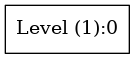

LEVEL 1  PARENT: Level
Entropy(Class|Value<3)=0
Entropy(Class|Value>=3)=0.5916727785823275
Gain(Class|Value=3)=0.025850761940059863
Entropy(Class|Value<6)=0
Entropy(Class|Value>=6)=0.6500224216483541
Gain(Class|Value=6)=0.05604762696333082
Entropy(Class|Value<11)=0.9182958340544896
Entropy(Class|Value>=11)=0
Gain(Class|Value=11)=0.19920350542916282
Entropy(Class|Value<16)=0.8112781244591328
Entropy(Class|Value>=16)=0
Gain(Class|Value=16)=0.13792538097003
Entropy(Class|Value<33)=0.7219280948873623
Entropy(Class|Value>=33)=0
Gain(Class|Value=33)=0.09235938389499498
Entropy(Class|Value<45)=0.6500224216483541
Entropy(Class|Value>=45)=0
Gain(Class|Value=45)=0.05604762696333082
Entropy(Class|Value<50)=0.5916727785823275
Entropy(Class|Value>=50)=0
Gain(Class|Value=50)=0.025850761940059863
Maximum gain is:0.19920350542916282 corresponding to split 11

H(Class)=0.5435644431995964
Entropy(Class|Color='BLUE')=0
Entropy(Class|Color='RED')=0.7219280948873623
Entropy(Class|Color)=0.4512050593046014


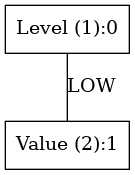

LEVEL 2  PARENT: Value
H(Class)=0.9182958340544896
Entropy(Class|Color='BLUE')=0
Entropy(Class|Color='RED')=1.0
Entropy(Class|Color)=0.6666666666666666
Gain(Class|Color)=0.2516291673878229
Entropy(Class|Size='SMALL')=1.0
Entropy(Class|Size='LARGE')=0
Entropy(Class|Size)=0.6666666666666666
Gain(Class|Size)=0.2516291673878229
Entropy(Class|Temp='COOL')=0.9182958340544896
Entropy(Class|Temp)=0.9182958340544896
Gain(Class|Temp)=0.0



Best Attribute for left node of parent  Value  for Level  2  is  Color


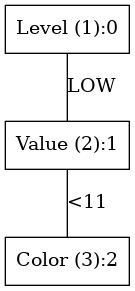

All classes same
ResultClass for left node of ' Color ' =  F


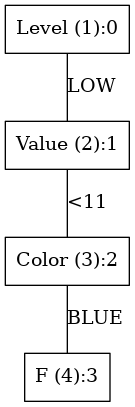

LEVEL 3  PARENT: Color
H(Class)=1.0
Entropy(Class|Size='LARGE')=0
Entropy(Class|Size='SMALL')=0
Entropy(Class|Size)=0.0
Gain(Class|Size)=1.0
Entropy(Class|Temp='COOL')=1.0
Entropy(Class|Temp)=1.0
Gain(Class|Temp)=0.0



Best Attribute for right node of parent  Color  for Level  3  is  Size


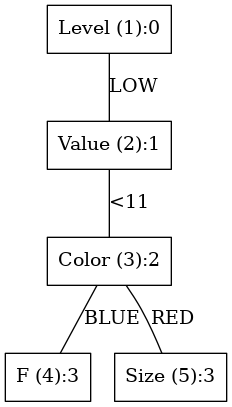

All classes same
ResultClass for left node of ' Size ' =  F


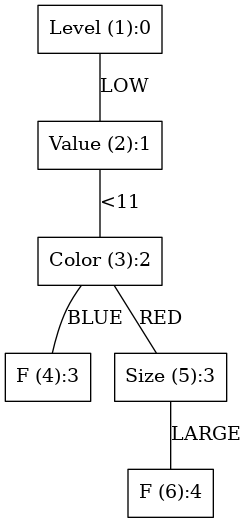

All classes same
ResultClass for right node of ' Size ' =  T


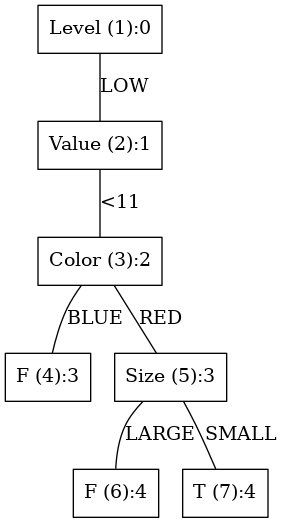

All classes same
ResultClass for right node of ' Value ' =  F


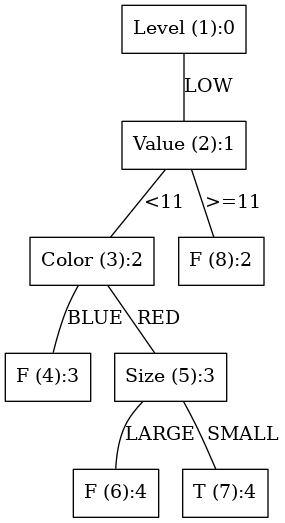

LEVEL 1  PARENT: Level
Entropy(Class|Value<10)=0
Entropy(Class|Value>=10)=0.5916727785823275
Gain(Class|Value=10)=0.2935644431995963
Entropy(Class|Value<17)=1.0
Entropy(Class|Value>=17)=0.6500224216483541
Gain(Class|Value=17)=0.0737613082228673
Entropy(Class|Value<25)=0.9182958340544896
Entropy(Class|Value>=25)=0
Gain(Class|Value=25)=0.46691718668869925
Entropy(Class|Value<27)=1.0
Entropy(Class|Value>=27)=0
Gain(Class|Value=27)=0.31127812445913283
Entropy(Class|Value<29)=0.9709505944546686
Entropy(Class|Value>=29)=0
Gain(Class|Value=29)=0.20443400292496494
Entropy(Class|Value<34)=0.9182958340544896
Entropy(Class|Value>=34)=0
Gain(Class|Value=34)=0.12255624891826566
Entropy(Class|Value<36)=0.863120568566631
Entropy(Class|Value>=36)=0
Gain(Class|Value=36)=0.056047626963330655
Maximum gain is:0.46691718668869925 corresponding to split 25

H(Class)=0.8112781244591328
Entropy(Class|Color='BLUE')=0.9709505944546686
Entropy(Class|Color='RED')=0
Entropy(Class|Color)=0.6068441215341679
Gain(Cla

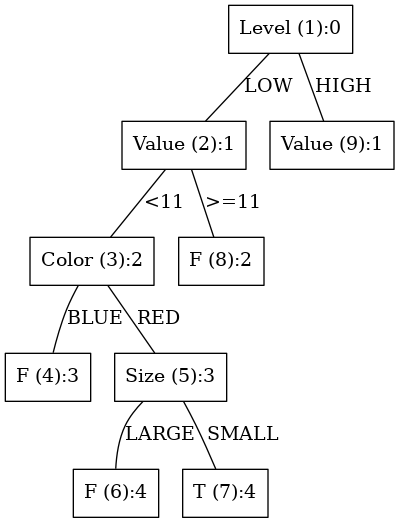

LEVEL 2  PARENT: Value
H(Class)=0.9182958340544896
Entropy(Class|Color='BLUE')=0
Entropy(Class|Color='RED')=0
Entropy(Class|Color)=0.0
Gain(Class|Color)=0.9182958340544896
Entropy(Class|Size='LARGE')=0
Entropy(Class|Size='SMALL')=0
Entropy(Class|Size)=0.0
Gain(Class|Size)=0.9182958340544896
Entropy(Class|Temp='COOL')=0.9182958340544896
Entropy(Class|Temp)=0.9182958340544896
Gain(Class|Temp)=0.0



Best Attribute for left node of parent  Value  for Level  2  is  Color


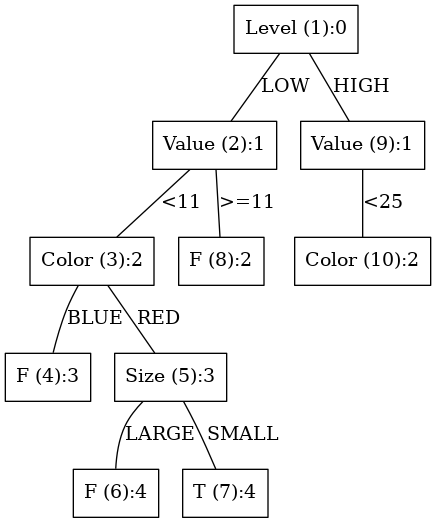

All classes same
ResultClass for left node of ' Color ' =  F


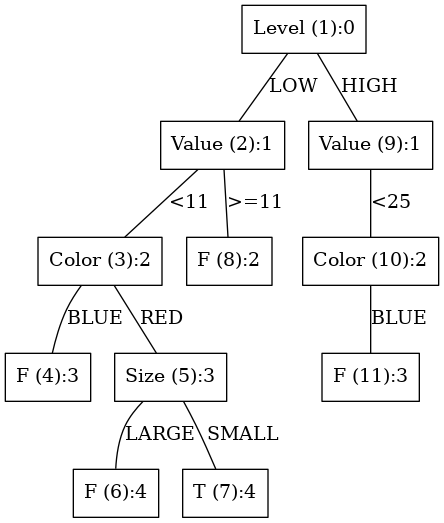

All classes same
ResultClass for right node of ' Color ' =  T


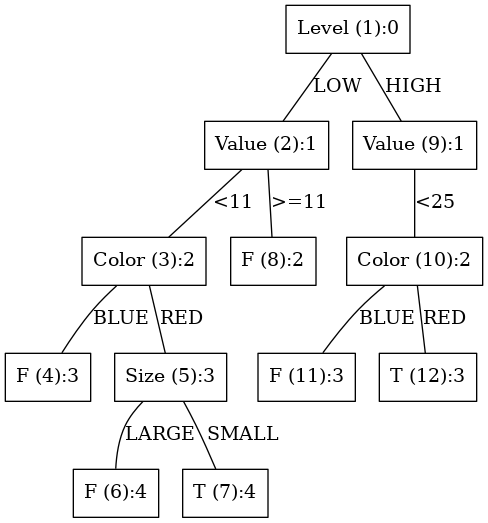

All classes same
ResultClass for right node of ' Value ' =  T


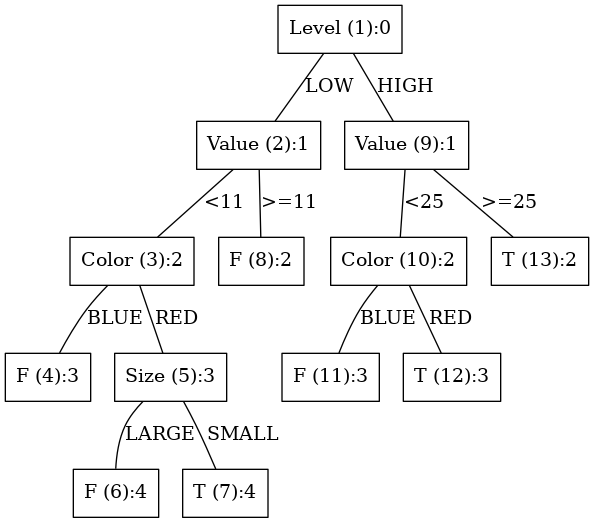

In [0]:
root = Node("root")
buildTree(root,df,0,ID3=True)

## (b) (10 points) Construct the tree manually using the Gini index, write down the computation process and show your tree step by step. (No partial credit)


LEVEL 0  PARENT None
Gini(Class|Value<3)=0
Gini(Class|Value>=3)=0.4977777777777777
GiniSplit(Class|Value=3)=0.4666666666666666
Gini(Class|Value<6)=0
Gini(Class|Value>=6)=0.5
GiniSplit(Class|Value=6)=0.4375
Gini(Class|Value<7)=0.4444444444444444
Gini(Class|Value>=7)=0.49704142011834324
GiniSplit(Class|Value=7)=0.48717948717948717
Gini(Class|Value<10)=0.375
Gini(Class|Value>=10)=0.5
GiniSplit(Class|Value=10)=0.46875
Gini(Class|Value<11)=0.48
Gini(Class|Value>=11)=0.4958677685950414
GiniSplit(Class|Value=11)=0.49090909090909096
Gini(Class|Value<16)=0.4444444444444444
Gini(Class|Value>=16)=0.5
GiniSplit(Class|Value=16)=0.47916666666666663
Gini(Class|Value<17)=0.40816326530612246
Gini(Class|Value>=17)=0.49382716049382713
GiniSplit(Class|Value=17)=0.4563492063492064
Gini(Class|Value<25)=0.375
Gini(Class|Value>=25)=0.46875
GiniSplit(Class|Value=25)=0.421875
Gini(Class|Value<27)=0.4444444444444444
Gini(Class|Value>=27)=0.489795918367347
GiniSplit(Class|Value=27)=0.4642857142857143
Gini(Class|V

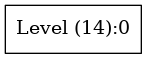

LEVEL 1  PARENT Level
Gini(Class|Value<3)=0
Gini(Class|Value>=3)=0.24489795918367352
GiniSplit(Class|Value=3)=0.21428571428571433
Gini(Class|Value<6)=0
Gini(Class|Value>=6)=0.2777777777777777
GiniSplit(Class|Value=6)=0.20833333333333326
Gini(Class|Value<11)=0.4444444444444444
Gini(Class|Value>=11)=0
GiniSplit(Class|Value=11)=0.16666666666666666
Gini(Class|Value<16)=0.375
Gini(Class|Value>=16)=0
GiniSplit(Class|Value=16)=0.1875
Gini(Class|Value<33)=0.3199999999999999
Gini(Class|Value>=33)=0
GiniSplit(Class|Value=33)=0.19999999999999993
Gini(Class|Value<45)=0.2777777777777777
Gini(Class|Value>=45)=0
GiniSplit(Class|Value=45)=0.20833333333333326
Gini(Class|Value<50)=0.24489795918367352
Gini(Class|Value>=50)=0
GiniSplit(Class|Value=50)=0.21428571428571433
Minimum Gini-Split is:0.16666666666666666 corresponding to split 11

Gini(Class|Color='BLUE')=0
Gini(Class|Color='RED')=0.3199999999999999
Gini(Class|Color)=0.19999999999999993
Gini(Class|Size='SMALL')=0.3199999999999999
Gini(Class|Size='

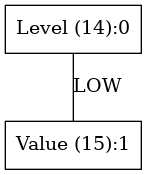

LEVEL 2  PARENT Value
Gini(Class|Color='BLUE')=0
Gini(Class|Color='RED')=0.5
Gini(Class|Color)=0.3333333333333333
Gini(Class|Size='SMALL')=0.5
Gini(Class|Size='LARGE')=0
Gini(Class|Size)=0.3333333333333333
Gini(Class|Temp='COOL')=0.4444444444444444
Gini(Class|Temp)=0.4444444444444444



Best Attribute for left node of parent  Value  for Level  2  is  Color


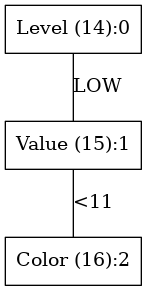

All classes same
ResultClass for left node of ' Color ' =  F


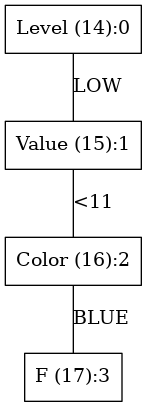

LEVEL 3  PARENT Color
Gini(Class|Size='LARGE')=0
Gini(Class|Size='SMALL')=0
Gini(Class|Size)=0.0
Gini(Class|Temp='COOL')=0.5
Gini(Class|Temp)=0.5



Best Attribute for right node of parent  Color  for Level  3  is  Size


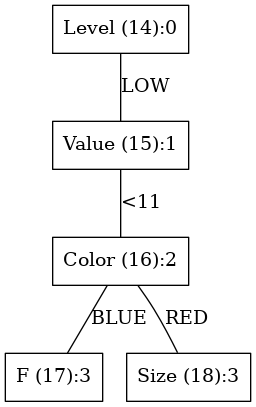

All classes same
ResultClass for left node of ' Size ' =  F


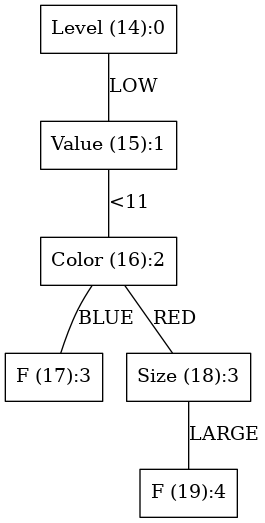

All classes same
ResultClass for right node of ' Size ' =  T


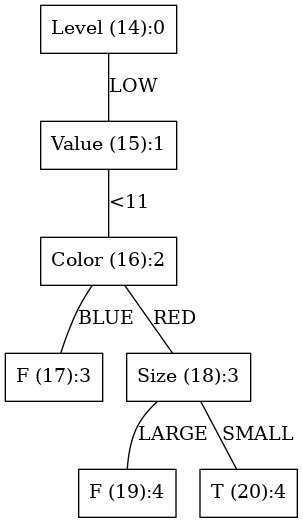

All classes same
ResultClass for right node of ' Value ' =  F


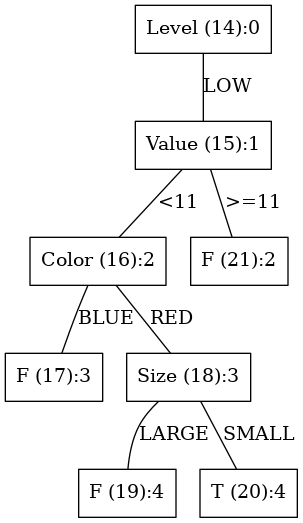

LEVEL 1  PARENT Level
Gini(Class|Value<10)=0
Gini(Class|Value>=10)=0.24489795918367352
GiniSplit(Class|Value=10)=0.21428571428571433
Gini(Class|Value<17)=0.5
Gini(Class|Value>=17)=0.2777777777777777
GiniSplit(Class|Value=17)=0.33333333333333326
Gini(Class|Value<25)=0.4444444444444444
Gini(Class|Value>=25)=0
GiniSplit(Class|Value=25)=0.16666666666666666
Gini(Class|Value<27)=0.5
Gini(Class|Value>=27)=0
GiniSplit(Class|Value=27)=0.25
Gini(Class|Value<29)=0.48
Gini(Class|Value>=29)=0
GiniSplit(Class|Value=29)=0.3
Gini(Class|Value<34)=0.4444444444444444
Gini(Class|Value>=34)=0
GiniSplit(Class|Value=34)=0.3333333333333333
Gini(Class|Value<36)=0.40816326530612246
Gini(Class|Value>=36)=0
GiniSplit(Class|Value=36)=0.35714285714285715
Minimum Gini-Split is:0.16666666666666666 corresponding to split 25

Gini(Class|Color='BLUE')=0.48
Gini(Class|Color='RED')=0
Gini(Class|Color)=0.3
Gini(Class|Size='LARGE')=0.48
Gini(Class|Size='SMALL')=0
Gini(Class|Size)=0.3
Gini(Class|Temp='COOL')=0.44444444444444

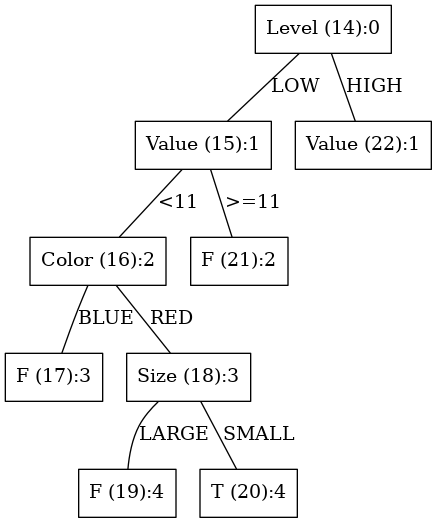

LEVEL 2  PARENT Value
Gini(Class|Color='BLUE')=0
Gini(Class|Color='RED')=0
Gini(Class|Color)=0.0
Gini(Class|Size='LARGE')=0
Gini(Class|Size='SMALL')=0
Gini(Class|Size)=0.0
Gini(Class|Temp='COOL')=0.4444444444444444
Gini(Class|Temp)=0.4444444444444444



Best Attribute for left node of parent  Value  for Level  2  is  Color


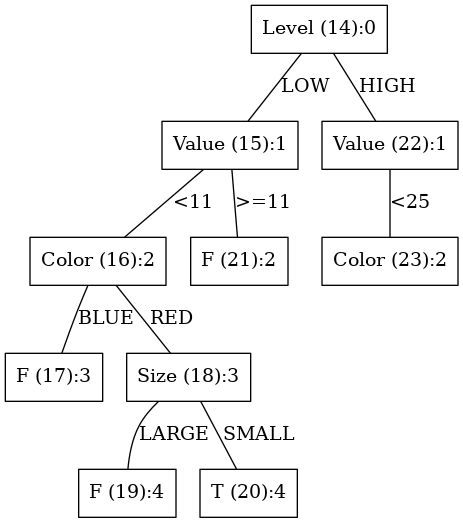

All classes same
ResultClass for left node of ' Color ' =  F


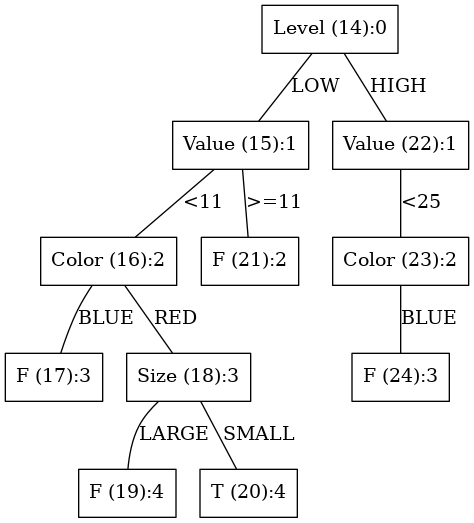

All classes same
ResultClass for right node of ' Color ' =  T


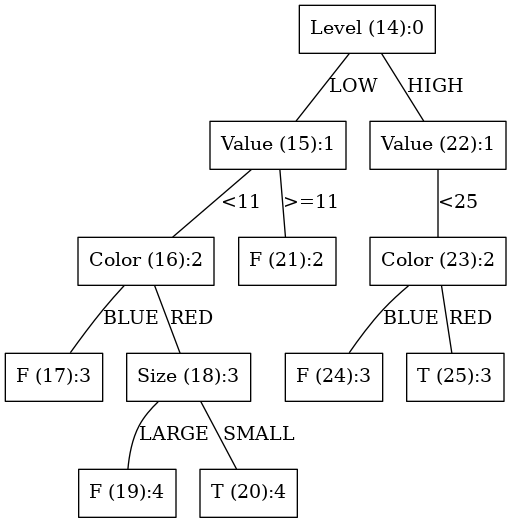

All classes same
ResultClass for right node of ' Value ' =  T


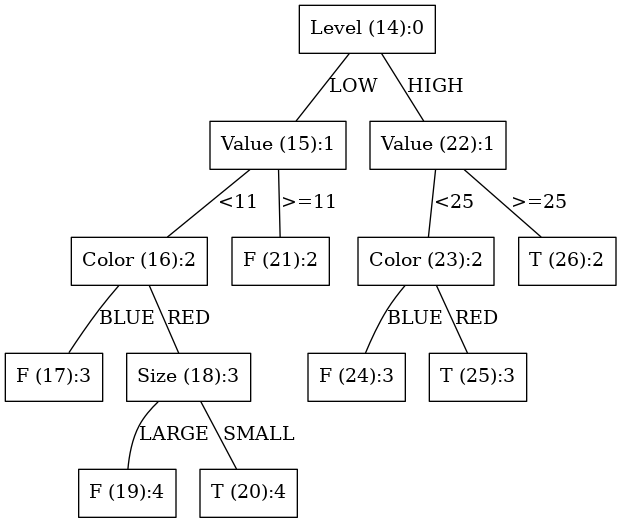

In [0]:
root = Node("root")
buildTree(root,df,0,ID3=False)